## Figure 3

Code to reproduce Figure 3.

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import os

In [2]:
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['legend.edgecolor']='black'
plt.rcParams['axes.linewidth']='0.8'
plt.rcParams['xtick.bottom']= 'True'
plt.rcParams['ytick.left']= 'True'
plt.rcParams['xtick.color']='black'
plt.rcParams['ytick.color']='black'
plt.rcParams['xtick.major.size']='3.5'
plt.rcParams['ytick.major.size']='3.5'
plt.rcParams['xtick.major.width']='0.8'
plt.rcParams['ytick.major.width']='0.8'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

plt.rc('font', size=16)   
plt.rc('axes', titlesize=16)    
plt.rc('axes', labelsize=16)   
plt.rc('xtick', labelsize=16)   
plt.rc('ytick', labelsize=16)    
plt.rc('legend', fontsize=16)  
plt.rc('figure', titlesize=20) 

## Read files

In [3]:
#os.chdir('/gws/nopw/j04/vplume/mchim/netcdf_files/')
os.chdir('<input-directory-path>')

df_toc = pd.read_csv('TOC_NASA_toms+omi+omps.txt', sep='\s+')
df_toc.drop(16, inplace=True)

ukesm11_hist_presc = ['by791','bz502','bz897']

ukesm11_hist = {'ukesm11_hist_presc': ukesm11_hist_presc}

for idx in ukesm11_hist:
    ds_list = []
    suite_id = ukesm11_hist[idx]
    
    ds_list = [xr.open_dataset('Ozone_monthly/'+f'u-{id}_monthly_volc_ozone.nc').sel({'model_level_number': 1}) 
               for id in suite_id]

    ds_temp = xr.concat(ds_list, dim='ensemble')

    ukesm11_hist[idx] = ds_temp

## Functions

In [4]:
def plot_ukesm11(ax, year, df):
    ax.plot(year, df['mean']['ukesm11_hist_presc'], 
            color = 'navy',label = 'UKESM1.1 Prescribed', linewidth = 2)
    
    ax.fill_between(year, df['mean']['ukesm11_hist_presc'], df['min']['ukesm11_hist_presc'], 
                    color='lightblue', alpha=0.3)

    ax.fill_between(year, df['mean']['ukesm11_hist_presc'], df['max']['ukesm11_hist_presc'], 
                    color='lightblue', alpha=0.3)

def plot_scatter(ax, lat):
    ax.scatter(df_toc.Year, df_toc[lat], color = 'red', label = 'Satellite measurement', s = 10)


In [5]:
def calc_toc_SH_pole_oct(df):

    def is_oct(month):
        return (month == 10)
  
    temp = df[:,:,0:24,:]
    weights = np.cos(np.deg2rad(temp.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])
    zonal_sum = temp_w.mean(dim=['longitude'])

    toc = toc_sum.sel(time=is_oct(toc_sum['time.month']))
    zonal_ensem = zonal_sum.sel(time=is_oct(zonal_sum['time.month'])).mean(dim='ensemble')
    
    return toc, zonal_ensem

def calc_toc_NH_pole_mar(df):

    def is_mar(month):
        return (month == 3)
  
    temp = df[:,:,120:144,:]
    weights = np.cos(np.deg2rad(temp.latitude[0:24]))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])
    zonal_sum = temp_w.mean(dim=['longitude'])

    toc = toc_sum.sel(time=is_mar(toc_sum['time.month']))
    zonal_ensem = zonal_sum.sel(time=is_mar(zonal_sum['time.month'])).mean(dim='ensemble')
    
    return toc, zonal_ensem

def calc_toc_by_lat_bands(df,l1,l2):

    '''
    Index for latitude
    0:24 = -90 to -60S Antarctic
    24:48 = -60 to -30S SH midlat
    56:88 = 20S to 20N tropics
    96:120 = 30 to 60N NH midlat
    120:144 = 60 to 90N Arctic
    '''
    temp = df[:,:,l1:l2,:]
    weights = np.cos(np.deg2rad(temp.latitude))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])
    zonal_sum = temp_w.mean(dim=['longitude'])

    toc = toc_sum.resample(time='Y').mean(dim='time')
    zonal_ensem = zonal_sum.mean(dim='ensemble')
    
    return toc, zonal_ensem


def calc_mean_max_min(df):
    
    df_mean = df.mean(dim='ensemble')
    df_max = df.max(dim='ensemble')
    df_min = df.min(dim='ensemble')
    
    return df_mean, df_max, df_min

def calc_toc_global(df):
 
    temp = df[:,:,:]
    weights = np.cos(np.deg2rad(temp.latitude))
    weights.name = "weights"
    temp_w = temp.weighted(weights)
    toc_sum = temp_w.mean(dim=['latitude','longitude'])
    zonal_sum = temp_w.mean(dim=['longitude'])

    toc = toc_sum.resample(time='Y').mean(dim='time')
    zonal_ensem = zonal_sum.mean(dim='ensemble')
    
    return toc, zonal_ensem

## Calculations

In [6]:
# Dictionary for storing annual TOC Antartic (60S-90S) in October, Oct daily fields
df_antar = {'mean': {}, 'zonal': {}, 'max': {}, 'min': {}}
# Dictionary for storing annual TOC Arctic (60S-90S) in March, Mar daily fields
df_arctic = {'mean': {}, 'zonal': {}, 'max': {}, 'min': {}}
# Global average for 60-30S SH mid-latitudes (index 24:48), daily fields
df_SH_midlat = {'mean': {}, 'zonal': {}, 'max': {}, 'min': {}}
# Global average for 20S to 20N tropics (index 56:88), daily fields
df_tropics = {'mean': {}, 'zonal': {}, 'max': {}, 'min': {}}
# Global average for 30-60N NH mid-latitudes (index 96:120), daily fields
df_NH_midlat = {'mean': {}, 'zonal': {}, 'max': {}, 'min': {}}
# Global average 
df_global = {'mean': {}, 'zonal': {}, 'max': {}, 'min': {}}


for idx in ukesm11_hist:
    for i in range(len(ukesm11_hist[idx])):
        
        antar_oct, antar_zonal = calc_toc_SH_pole_oct(ukesm11_hist[idx].m01s50i219)
        antar_mean, antar_max, antar_min = calc_mean_max_min(antar_oct)
        df_antar['mean'][idx] = antar_mean
        df_antar['zonal'][idx] = antar_zonal
        df_antar['max'][idx] = antar_max
        df_antar['min'][idx] = antar_min
    
        arctic_mar, arctic_zonal = calc_toc_NH_pole_mar(ukesm11_hist[idx].m01s50i219)
        arctic_mean, arctic_max, arctic_min = calc_mean_max_min(arctic_mar)
        df_arctic['mean'][idx] = arctic_mean
        df_arctic['zonal'][idx] = arctic_zonal
        df_arctic['max'][idx] = arctic_max
        df_arctic['min'][idx] = arctic_min
    
        SH_midlat, SH_midlat_zonal = calc_toc_by_lat_bands(ukesm11_hist[idx].m01s50i219,24,48)
        SH_midlat_mean, SH_midlat_max, SH_midlat_min = calc_mean_max_min(SH_midlat)
        df_SH_midlat['mean'][idx] = SH_midlat_mean
        df_SH_midlat['zonal'][idx] = SH_midlat_zonal
        df_SH_midlat['max'][idx] = SH_midlat_max
        df_SH_midlat['min'][idx] = SH_midlat_min
    
        NH_midlat, NH_midlat_zonal = calc_toc_by_lat_bands(ukesm11_hist[idx].m01s50i219,96,120)
        NH_midlat_mean, NH_midlat_max, NH_midlat_min = calc_mean_max_min(NH_midlat)
        df_NH_midlat['mean'][idx] = NH_midlat_mean
        df_NH_midlat['zonal'][idx] = NH_midlat_zonal
        df_NH_midlat['max'][idx] = NH_midlat_max
        df_NH_midlat['min'][idx] = NH_midlat_min
    
        tropics, tropics_zonal = calc_toc_by_lat_bands(ukesm11_hist[idx].m01s50i219,56,88)
        tropics_mean, tropics_max, tropics_min = calc_mean_max_min(tropics)
        df_tropics['mean'][idx] = tropics_mean
        df_tropics['zonal'][idx] = tropics_zonal
        df_tropics['max'][idx] = tropics_max
        df_tropics['min'][idx] = tropics_min

        globalmean, global_zonal = calc_toc_global(ukesm11_hist[idx].m01s50i219)
        global_mean, global_max, global_min = calc_mean_max_min(globalmean)
        df_global['mean'][idx] = global_mean
        df_global['zonal'][idx] = global_zonal
        df_global['max'][idx] = global_max
        df_global['min'][idx] = global_min

## Plots

Text(0.0, 1.0, 'NH mid-latitudes ')

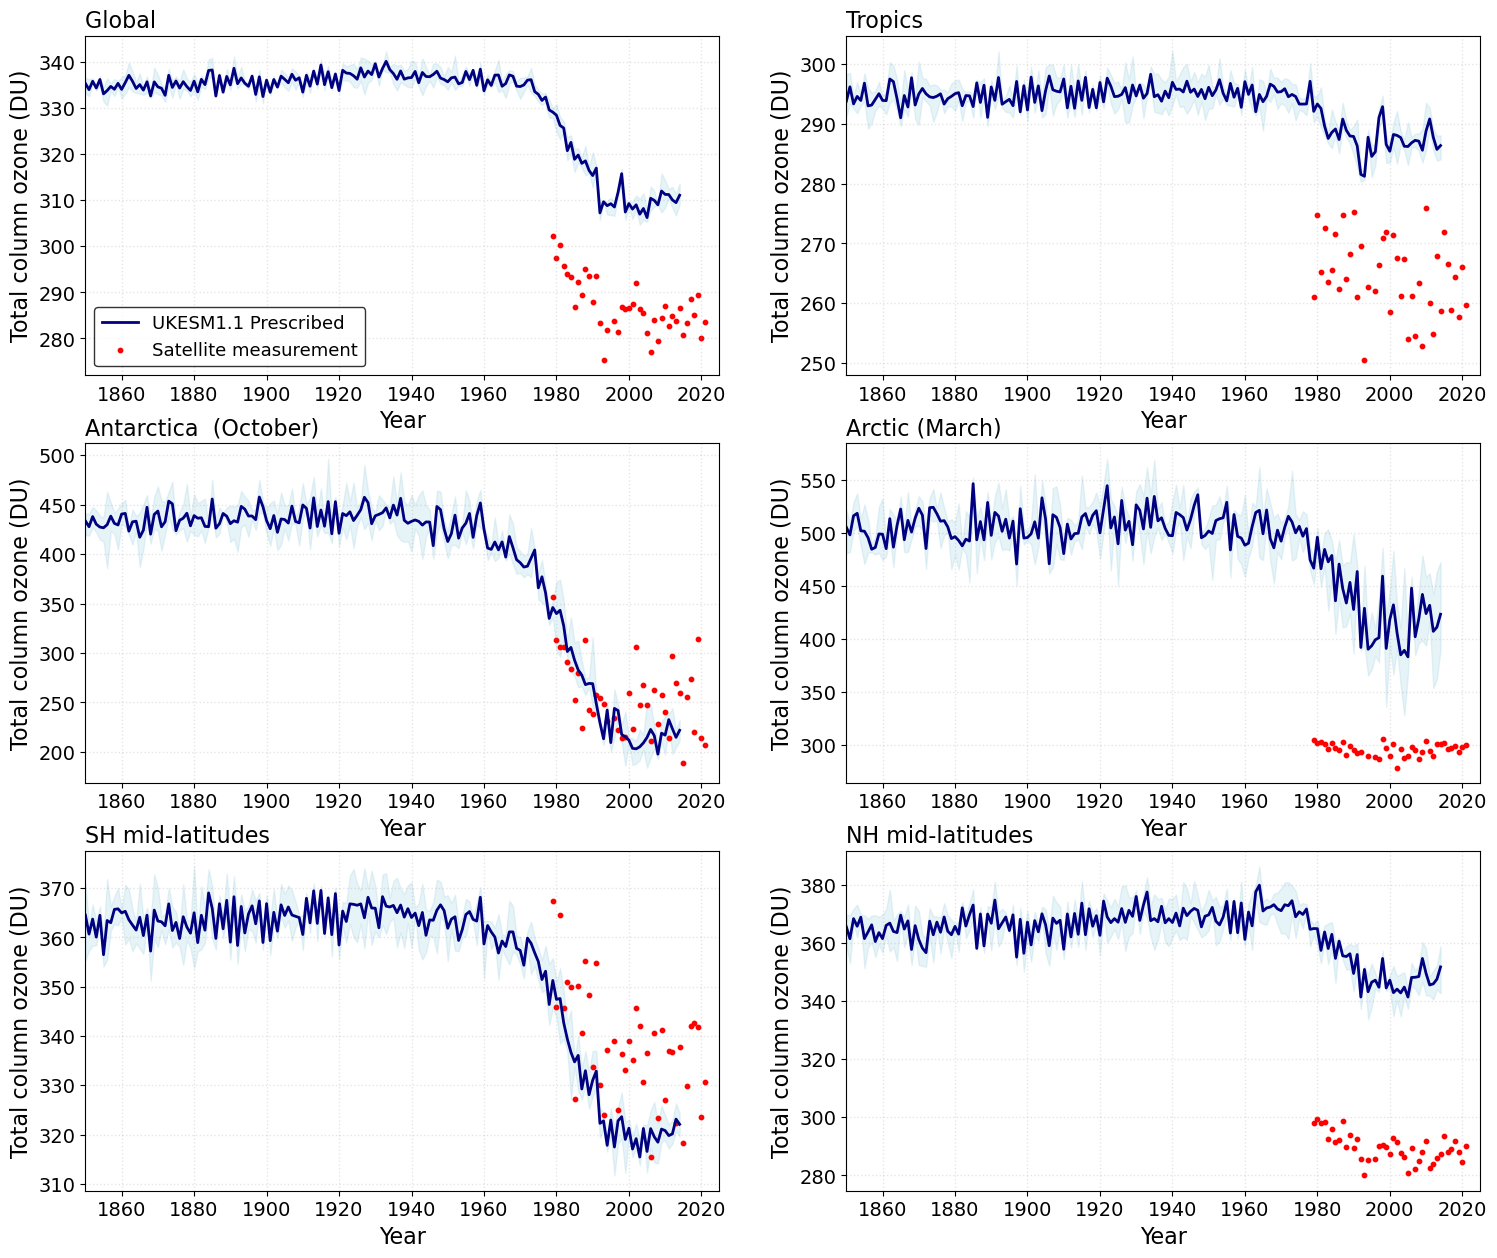

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(18,15),dpi=100)

year_axis = np.arange(1850,2015,1)
year_axis2 = np.arange(1850,2014,1)

# Global average
plot_ukesm11(ax[0,0], year_axis, df_global)
plot_scatter(ax[0,0], 'Global')

# Antarctic October
plot_ukesm11(ax[1,0], year_axis, df_antar)
plot_scatter(ax[1,0], '90S--60S')

# SH mid latitudes
plot_ukesm11(ax[2,0], year_axis, df_SH_midlat)
plot_scatter(ax[2,0], '60S--30S')

# Tropics
plot_ukesm11(ax[0,1], year_axis, df_tropics)
plot_scatter(ax[0,1], '10S--10N')

# Arctic March
plot_ukesm11(ax[1,1], year_axis, df_arctic)
plot_scatter(ax[1,1], '60N--90N')

# NH mid-latitudes
plot_ukesm11(ax[2,1], year_axis, df_NH_midlat)
plot_scatter(ax[2,1], '30N--60N')

#figure adjustment
for axis in ax.flat:
    axis.tick_params(axis='y', labelsize=14)
    axis.tick_params(axis='x', labelsize=14)
    axis.set_ylabel('Total column ozone (DU)', fontsize=16)
    axis.set_xlabel('Year',fontsize=16)
    axis.set_xlim(1850,2025)
    axis.grid(color='grey', which = 'both', linestyle='dotted', linewidth=1, alpha = 0.2)

ax[0,0].legend(fontsize = 13, loc = 'lower left')

ax[0,0].set_title('Global  ', loc = 'left', y=1.0, fontsize = 16)
ax[1,0].set_title('Antarctica  (October)', loc = 'left', y=1.0, fontsize = 16)
ax[2,0].set_title('SH mid-latitudes  ', loc = 'left', y=1.0, fontsize = 16)
ax[0,1].set_title('Tropics ', loc = 'left', y=1.0, fontsize = 16)
ax[1,1].set_title('Arctic (March)', loc = 'left', y=1.0, fontsize = 16)
ax[2,1].set_title('NH mid-latitudes ', loc = 'left', y=1.0, fontsize = 16)
